In [5]:
# Load libraries
import pandas as pd
from sklearn import linear_model 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score, balanced_accuracy_score
#from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score
import pandas as pd
import numpy as np
from scipy.stats import stats
import os
import matplotlib.pyplot as plt
from random import choices
import xgboost as xgb
import xgboost as XGBClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score


In [44]:
# Define functions

def Filter_low_Expr(arr):
    
    #input: arr: a list of expression values for a gene across all samples
    #output: True or False that indicates whether this gene show expression greater than 0 in more than 50% of the samples
    
    total_len = len(arr)
    count = 0
    for i in arr:
        if i > 0:
            count = count + 1
    if count > 0.5*total_len: #If 
        return(True)
    else:
        return(False)
    
def formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map):
    array_list = []
    new_id_list = []
    for gene1 in selected_genes_id:

        for gene2 in sele_house_keeping_id:
            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    for gene1 in selected_genes_id:
        cur_sele = KG_reg.loc[KG_reg['Target_gene'] == gene1]
        cur_regulators = list(cur_sele.loc[cur_sele['Coef'] < 0]['Regulator'])
        if gene1+"_intercept_" in cur_regulators:
            cur_regulators.remove(gene1+"_intercept_")
        #cur_regulators.remove(gene1+"_RSS")
        cur_regulators_ids = []
        for gene2 in cur_regulators:
            gene2 = dic_gene_map[gene2]
            #cur_regulators_ids.append(dic_gene_map[i])

            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    new_feature_df = pd.DataFrame(array_list)
    new_feature_df.columns = input_data.columns
    new_feature_df.index = new_id_list
    new_feature_df_t = new_feature_df.transpose()
    return(new_feature_df_t)


def train_test_split_gq(df_sele, binary_cutoff, test_size): #stratified sampling
    from sklearn.model_selection import train_test_split
    df_neg = df_sele.loc[df_sele['ic50'] > binary_cutoff]
    df_train_1, df_test_1 = train_test_split(df_neg, test_size = test_size)
    df_pos = df_sele.loc[df_sele['ic50'] <= binary_cutoff]
    df_train_2, df_test_2 = train_test_split(df_pos, test_size = test_size)
    
    df_train = pd.concat([df_train_1,df_train_2])
    df_test = pd.concat([df_test_1, df_test_2])
    
    return(df_train, df_test)
def model_run_with_Independent_crossvalidation(train_data,test_data, train_labels, test_labels, independent_labels, independent_features,random_): #modified at 11:46 AM Feb 15
    result_summary = {}
    
    if len(independent_labels) <= 1:
        return(result_summary)
    
    xgb_model = xgb.XGBClassifier(n_jobs=4)
    clf = GridSearchCV(xgb_model, {#'max_depth': [2],
                                   'max_depth': [2,3,4],
                                   'n_estimators': [100], 
                                   'learning_rate': [0.05, 0.1],
                                   #'gamma':[1],
                                   #'eta':[0.2,0.3,0.4],
                                  # 'min_child_weight':[1,2],
                                  # 'lambda':[1,2],
                                  # 'subsample':[0.8]
                                  },
                                  refit=True, 
                                  verbose=0, 
                                  cv=5, 
                                  n_jobs=4, 
                                  return_train_score=True,
                                  scoring = 'balanced_accuracy') #5-fold cross validation

    clf.fit(train_data, train_labels.values)

    print("clf.best_score_: balanced_accuracy: ")
    print(clf.best_score_) #Train data

    print("clf.best_params_:")
    para = (clf.best_params_)
    print(clf.best_params_)

    xgb_model = xgb.XGBClassifier(n_jobs=1, learning_rate = para['learning_rate'], 
                                  max_depth=para['max_depth'], 
                                  n_estimators=para['n_estimators'])
    
    xgb_model.fit(train_data,train_labels.values)



    #blanced_acc_traing = clf.best_score_
    #print("blanced_acc_traing:" + str(blanced_acc_traing))
    #acc_traing = accuracy_score(train_labels, predictions_training)
    #print("acc_traing:" + str(acc_traing))
    #f1_traing = f1_score(list(train_labels), predictions_training)
    #print("f1_traing:" + str(f1_traing))

    predictions = clf.predict(test_data)
    predictions_independent = clf.predict(independent_features)
    
    accuracy = accuracy_score(test_labels, predictions)
    print("accuracy_test_w1/2:" + str(accuracy))
    blanced_acc = balanced_accuracy_score(test_labels, predictions) #(sensitivity + specificity) /2 
    print("balanced_accuracy_test_w1/2:" + str(blanced_acc))
    f1 = f1_score(test_labels, predictions)
    print("f1_test_w1/2:" + str(f1))

    # Evaluate the accuracy of the XGBoost model in the testing set (beatAML wave 3/4)
    #accuracy_independent = accuracy_score(independent_labels, predictions_independent)
    f1_independent = f1_score(independent_labels, predictions_independent)
    print("f1_independent:" + str(f1_independent))
    blanced_acc_independent = balanced_accuracy_score(independent_labels, predictions_independent) #(sensitivity_independent + specificity_independent) /2 
    print("blanced_acc_independent:" + str(blanced_acc_independent))

    result_feature = pd.DataFrame({"Feature":list(test_data.columns), "IMP":xgb_model.feature_importances_})
    result_feature= result_feature.loc[result_feature['IMP']>0].sort_values(by = ['IMP'], ascending = False)

    #features = ((list(result_feature.loc[result_feature['IMP']>0.05].sort_values(by = ["IMP"], ascending = False)['Feature'])))

    
    result_summary['random_state'] = random_
    result_summary['best_params'] = clf.best_params_

    
    #result_summary['F1_score_training'] = f1_traing
    result_summary['balanced_acc_training'] = clf.best_score_
    
    result_summary['Accuracy'] = accuracy #1
    
    result_summary['F1_score'] = f1 #4
    
    result_summary['balanced_acc'] = blanced_acc #6
    
    
    
    result_summary['blanced_acc_independent'] = blanced_acc_independent #4
    result_summary['F1_score_independent'] = f1_independent #6
    
    result_summary['features'] = result_feature
    return(result_summary)

def model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, independent_labels, independent_features,random_): #modified at 11:46 AM Feb 15
    result_summary = {}
    
    if len(independent_labels) <= 1:
        return(result_summary)
    
    xgb_model = xgb.XGBClassifier(n_jobs=4)
    clf = GridSearchCV(xgb_model, {#'max_depth': [2],
                                   'max_depth': [2,3,4],
                                   'n_estimators': [ 100], 
                                   'learning_rate': [ 0.05],
                                  
                                   #'gamma':[1],
                                   #'eta':[0.2,0.3,0.4],
                                  # 'min_child_weight':[1,2],
                                  # 'lambda':[1,2],
                                  # 'subsample':[0.8]
                                  }, verbose=1,cv=5, n_jobs=4) #5-fold cross validation

    clf.fit(train_data, train_labels.values)
    #print(clf.best_score_) #Train data
    para = (clf.best_params_)
    #print(clf.best_params_)

    xgb_model = xgb.XGBClassifier(n_jobs=1, learning_rate = para['learning_rate'], 
                                  max_depth=para['max_depth'], 
                                  n_estimators=para['n_estimators'])
    
    xgb_model.fit(train_data,train_labels.values)

    #prediction_train = clf.predict(train_data)

    #predictions = xgb_model.predict(test_data)

    predictions_training = clf.predict(train_data)
    accuracy_traing = accuracy_score(train_labels, predictions_training)
    #cm_traing = confusion_matrix(  list(train_labels), predictions_training)
    #sensitivity_traing = cm_traing[1,1]/(cm_traing[1,0] + cm_traing[1,1])
    #specificity_traing = cm_traing[0,0]/(cm_traing[0,0] + cm_traing[0,1])
    #precision_traing = cm_traing[1,1]/(cm_traing[0,1] + cm_traing[1,1])
    recall_traing = recall_score(train_labels, predictions_training)
    blanced_acc_traing = balanced_accuracy_score(train_labels, predictions_training) #(sensitivity_traing + specificity_traing) /2
    f1_traing = f1_score(list(train_labels), predictions_training)

    
    predictions = clf.predict(test_data)
    
    predictions_independent = clf.predict(independent_features)
    

    #print(pd.DataFrame({"Meausred": list(test_labels), "Predict": predictions}))

    # Evaluate the accuracy of the XGBoost model in the validation set (beatAML wave 1/2)
    accuracy = accuracy_score(test_labels, predictions)
    #cm = confusion_matrix(  list(test_labels), predictions)
    #print("cm:")
    #print(cm)
    #tn = cm[0,0] #labled as negative and predicted as negative 
    #fp = cm[0,1] #labeld as negative and predicted as positive
    #fn = cm[1,0] #labeld as positive, and predicted as negative
    #tp = cm[1,1] #labeld as positive, and predicted as positive
    
    #sensitivity = cm[1,1]/(cm[1,0] + cm[1,1]) # TP/(FN + TP)
    #specificity = tn/(tn+fp)
    
    #precision = cm[1,1]/(cm[0,1] + cm[1,1])
    #recall = recall_score(test_labels, predictions)
    blanced_acc = balanced_accuracy_score(test_labels, predictions) #(sensitivity + specificity) /2 
    f1 = f1_score(test_labels, predictions)
    
    # Evaluate the accuracy of the XGBoost model in the testing set (beatAML wave 3/4)
    #accuracy_independent = accuracy_score(independent_labels, predictions_independent)
    f1_independent = f1_score(independent_labels, predictions_independent)
    #cm_independent = confusion_matrix(  list(independent_labels), predictions_independent)
    #print("cm_independent:")
    #print(cm_independent)
    #print(cm_independent)
    #tn_independent = cm_independent[0,0] #labled as negative and predicted as negative 
    #fp_independent = cm_independent[0,1] #labeld as negative and predicted as positive
    #fn_independent = cm_independent[1,0] #labeld as positive, and predicted as negative
    #tp_independent = cm_independent[1,1] #labeld as positive, and predicted as positive
    
    #sensitivity_independent = cm_independent[1,1]/(cm_independent[1,0] + cm_independent[1,1]) # TP/(FN + TP)
    
    #specificity_independent = tn_independent/(tn_independent+fp_independent)
    
    #precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
    #recall_independent = recall_score(independent_labels, predictions_independent)
    blanced_acc_independent = balanced_accuracy_score(independent_labels, predictions_independent) #(sensitivity_independent + specificity_independent) /2 
    recall_independent = recall_score(independent_labels, predictions_independent)
    # F1 = 2 x [(Precision x Recall) / (Precision + Recall)]

    #print("F1_score: " + str(f1))
    #print("# F1: 2 x [(Precision x Recall) / (Precision + Recall)]")

    result_feature = pd.DataFrame({"Feature":list(test_data.columns), "IMP":xgb_model.feature_importances_})
    result_feature= result_feature.loc[result_feature['IMP']>0].sort_values(by = ['IMP'], ascending = False)

    #features = ((list(result_feature.loc[result_feature['IMP']>0.05].sort_values(by = ["IMP"], ascending = False)['Feature'])))

    
    result_summary['random_state'] = random_
    result_summary['best_params'] = clf.best_params_

    #result_summary['Acuracy_training'] = accuracy_traing
    #result_summary['Precision_training'] = precision_traing
    #result_summary['sensitivity_training'] = sensitivity_traing
    result_summary['F1_score_training'] = f1_traing
    #result_summary['specificity_training'] = specificity_traing
    result_summary['balanced_acc_training'] = blanced_acc_traing
    #result_summary['recall_training'] = recall_traing
    
    result_summary['Accuracy'] = accuracy #1
    #result_summary['Precision'] = precision #2
    #result_summary['sensitivity'] = sensitivity #3
    result_summary['F1_score'] = f1 #4
    #result_summary['specificity'] = specificity #5
    result_summary['balanced_acc'] = blanced_acc #6
    #result_summary['recall'] = recall #7
    
    
    #result_summary['precision_independent'] = precision_independent #1
    #result_summary['sensitivity_independent'] =sensitivity_independent #2
    #result_summary['specificity_independent'] = specificity_independent #3
    result_summary['blanced_acc_independent'] = blanced_acc_independent #4
    #result_summary['ACC_independent'] = accuracy_independent #5
    result_summary['F1_score_independent'] = f1_independent #6
    #result_summary['recall_independent'] = recall_independent #7
    
    result_summary['features'] = result_feature
    return(result_summary)

def select_duplicated_col(my_list):
    duplicates = []
    for item in my_list:
        if my_list.count(item) > 1:
            if item not in duplicates:
                duplicates.append(item)
    return(duplicates)

def features(Drug, KG_expr_resp,KG_reg,dic_gene_map, input_data, input_data_test, BeatAML_mut_matrix_sele_w3_4, mut_w1_2, sele_house_keeping ):
    res1 = KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]
    res1 = res1.sort_values(by = ['coef'])
    predictors = list(res1['Gene'])
    predictors.remove(Drug+"_RSS")
    predictors.remove(Drug+"_intercept")
    
    # Selection of the second neighbors
    #res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors[0:5] +  predictors[len(predictors)-5:len(predictors)])]
    res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors)]
    res2 = res2.loc[res2['Coef'] <0]

    selected_genes = list(KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]['Symbol'])
    selected_genes.remove(Drug+"_RSS")
    selected_genes.remove(Drug+"_intercept")
        

    print(len(selected_genes))

    # Formating house keeping gene ids
    sele_house_keeping_id = []
    selected_genes_id = []

    for g in selected_genes:
        selected_genes_id.append(dic_gene_map[g])

    for g in sele_house_keeping:
        if g in dic_gene_map:
            sele_house_keeping_id.append(dic_gene_map[g])

    # Formatting features
    new_feature_df_t = formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map)
    new_feature_df_test = formating_relative_expression(input_data_test,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map)

    new_feature_df_test_comb = pd.concat([BeatAML_mut_matrix_sele_w3_4, new_feature_df_test], axis = 1)
    new_feature_df_t_comb = pd.concat([mut_w1_2,new_feature_df_t],axis = 1)

    new_feature_df_test = new_feature_df_test_comb.dropna()
    new_feature_df_t = new_feature_df_t_comb.dropna()

    return(new_feature_df_t,new_feature_df_test)


In [8]:
# Load data
# Gene expression from BeatAML wave 1 and 2
Drug_data = pd.read_csv("../../../Data_resource/Drug_Response.csv",index_col = "Unnamed: 0") 


GE = pd.read_csv("../../../Data_resource/RPKM.csv",index_col = "Unnamed: 0")
data_all  = pd.read_csv("./beatAML_wave1_2_feature_ic50_highExpr.csv", index_col= "Unnamed: 0")
mut_w1_2 = data_all.iloc[:,0:22].dropna()

#Load features from features that predict drug response, regulatory graph and house keeping genes
#sele_house_keeping =  ["GPS2", "RPS10","ZNF91","FNTA","PSMC1","GPS1","MLH1","ARAF","SF3B2","PSMD2","SRP14","GNB1","HNRNPK","ARF1","RPS11"]
sele_house_keeping = ['RPS10','FNTA','COX6A1','BECN1', 'SF3B2','PSMB2','AUP1','SRP14','HNRNPK', 'CCNI', 'RHOA', 'PABPC1','RPS11','TPT1','FTL']

#KG_expr_resp = pd.read_csv("../KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
#KG_reg = pd.read_csv("../KG_regulatory_graph.csv")

KG_expr_resp = pd.read_csv("../../../../Manuscript/Supplemental_Tables/Supplemental_2_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
KG_reg = pd.read_csv("KG_regulatory_graph_Mar1_2023.csv")


# Load testing data from BeatAML wave 1-4
BeatAML_wave_3_expr = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/rnaseq/beataml_waves1to4_allnorm.txt", sep = "\t") 
BeatAML_wave_3_drugResponse = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/inhibitor/beataml_probit_curve_fits_v4_distr_nonproprietary.txt", sep = "\t")
BeatAML_mut_matrix_sele_w3_4 = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/BeatAML_mut_matrix_sele_w3_4.csv", index_col = "Unnamed: 0")

In [9]:
#Formating gene expression data for training data
GE.index = GE['Gene']
gene_list_w12 = (list(GE.index))
sample_list_w12 = list(set(GE.columns) - set(['Gene','Symbol']))
input_data = GE.loc[list(gene_list_w12), sample_list_w12]


#Formating gene expression data for testing data
BeatAML_wave_3_expr.index = BeatAML_wave_3_expr['stable_id']
gene_list = (list(BeatAML_wave_3_expr.index))
sample_list = list(set(BeatAML_wave_3_expr.columns) - set(['stable_id','display_label','description','biotype']) - set(sample_list_w12))
input_data_test = BeatAML_wave_3_expr.loc[list(gene_list), sample_list]

# Define gene_map
gene_map = GE.loc[:,['Gene','Symbol']]
dic_gene_map = {}
for i in range(0,gene_map.shape[0]):
    dic_gene_map[gene_map.iloc[i,0]] = gene_map.iloc[i,1]
    dic_gene_map[gene_map.iloc[i,1]] = gene_map.iloc[i,0]


In [109]:
Drugs = pd.read_csv("/Users/guangrong/Documents/GitHub_project/AML_BeatAML/Manuscript/Supplemental_Tables/Supplemental_1_Number_of_effective_cases.csv")

Drugs = list(Drugs['Drug'])
print(Drugs)
print(len(Drugs))

['Elesclomol', 'Trametinib (GSK1120212)', 'Ponatinib (AP24534)', 'INK-128', 'Dasatinib', 'Panobinostat', 'JNJ-28312141', 'Rapamycin', 'Foretinib (XL880)', 'Quizartinib (AC220)', 'Venetoclax', 'Sunitinib', 'Dovitinib (CHIR-258)', 'Doramapimod (BIRB 796)', 'PI-103', 'SNS-032 (BMS-387032)', 'Selumetinib (AZD6244)', 'Flavopiridol', 'BEZ235', 'PP242', 'Gilteritinib (ASP-2215)', 'KI20227', 'JAK Inhibitor I', 'Tivozanib (AV-951)', 'Bortezomib (Velcade)', 'Lestaurtinib (CEP-701)', 'Midostaurin', 'Idelalisib', 'Cabozantinib', 'MK-2206', 'Sorafenib', 'Selinexor', '17-AAG (Tanespimycin)', 'Crenolanib', 'GDC-0941', 'KW-2449', 'RAF265 (CHIR-265)', 'MGCD-265', 'JQ1', 'Pelitinib (EKB-569)', 'CHIR-99021', 'Masitinib (AB-1010)', 'NF-kB Activation Inhibitor', 'CI-1040 (PD184352)', 'GSK690693', 'Neratinib (HKI-272)', 'NVP-TAE684', 'CYT387', 'S31-201', 'Ibrutinib (PCI-32765)', 'VX-745', 'A-674563', 'ABT-737', 'Axitinib (AG-013736)', 'Vandetanib (ZD6474)', 'Bosutinib (SKI-606)', 'Vargetef', 'Pazopanib (GW7

In [110]:
#Drug = "Venetoclax"
result_with_threshod = {}
for Drug in Drugs:
#for Drug in ["Venetoclax","Trametinib (GSK1120212)","JQ1"]:
    print("********************************************************")
    print(Drug)
    print("********************************************************")
    
    new_feature_df_t,new_feature_df_test = features(Drug, KG_expr_resp,KG_reg,dic_gene_map, input_data, input_data_test, BeatAML_mut_matrix_sele_w3_4, mut_w1_2, sele_house_keeping )
    result_with_threshod[Drug] = {}
    # Formatting trainning data
    Drug_sele_df = Drug_data.loc[Drug_data['inhibitor'] == Drug]
    Drug_sele_df.index = Drug_sele_df['lab_id']
    Drug_sele_df =Drug_sele_df.loc[:,['ic50']]

    df_sele = pd.concat([new_feature_df_t, Drug_sele_df],axis = 1)
    df_sele = df_sele.dropna()
    df_sele.head(3)
    df_sele.shape

    # Formatting testing data using beatAML wave 3/4
    Drug_sele_df_wave3 = BeatAML_wave_3_drugResponse.loc[BeatAML_wave_3_drugResponse['inhibitor'] == Drug]
    Drug_sele_df_wave3.index = Drug_sele_df_wave3['lab_id']
    Drug_sele_df_wave3 =Drug_sele_df_wave3.loc[:,['ic50']]

    df_sele__wave3 = pd.concat([new_feature_df_test, Drug_sele_df_wave3],axis = 1)
    df_sele__wave3 = df_sele__wave3.dropna()
    #df_sele__wave3.head(3)
    #df_sele__wave3.shape
    
    #q10 =np.quantile(Drug_sele_df['ic50'].values, q = 0.25)
    q25 =np.quantile(Drug_sele_df['ic50'].values, q = 0.25)
    q50 = np.quantile(Drug_sele_df['ic50'].values, q = 0.5)
    q75 = np.quantile(Drug_sele_df['ic50'].values, q = 0.75)

    threshold_list_label = []
    threshold_list = []
    if q25 < 10:
        threshold_list.append(q25)
        threshold_list_label.append("Q25:" + str(round(q25,2)) + "μM")
    if (q50 < 10 and q50 > q25):
        threshold_list.append(q50)
        threshold_list_label.append("Q50:" + str(round(q50,2)) + "μM")
    if (q75 < 10 and q75 > q50):
        threshold_list.append(q75)
        threshold_list_label.append("Q75:" + str(round(q75,2)) + "μM")
    #if q75 < 1:
    #    threshold_list.append(1)

    if len(threshold_list) >0:
        if max(threshold_list) < 1:
            threshold_list.append(1)
            threshold_list_label.append("1μM")
   # else:
   #     threshold_list.append(1)
   #     threshold_list_label.append("1μM")
        
    #if q75 < 1:
    threshold_list = list(set(threshold_list))
    if q25 > 10:
        print(Drug + ": high IC50")
        continue
    #print(threshold_list)
    
    for Threshod in threshold_list:
        print("Threshod" + str(Threshod))
        data_cur = df_sele # Step 1
        data_cur = data_cur.dropna()
        new_label = []
        for i in data_cur['ic50'].values:
            if i <= Threshod:
                new_label.append(1)
            else:
                new_label.append(0)
        data_cur[Drug+"_bi"] = new_label

        df_sele__wave3_cur = df_sele__wave3
        new_label = []
        for i in df_sele__wave3_cur['ic50'].values:
            if i <= Threshod:
                new_label.append(1)
            else:
                new_label.append(0)
        df_sele__wave3_cur[Drug+"_bi"] = new_label

        result_all = {}
        result_all_test_w3 = {}

        for random_ in range(0,100,10): 
            print("======================================================")
            sensitive_data = data_cur.loc[data_cur[Drug+"_bi"] == 1]
            resistant_data = data_cur.loc[data_cur[Drug+"_bi"] == 0]
            
            if (sensitive_data.shape[0] > 0 and resistant_data.shape[0] > 0):
                

                train_data_sen, test_data_sen, train_labels_sen, test_labels_sen = train_test_split(sensitive_data.iloc[:,:-2], 
                                                                                    sensitive_data.iloc[:,-1],
                                                                                    test_size = 0.2, random_state = random_)
                train_data_res, test_data_res, train_labels_res, test_labels_res = train_test_split(resistant_data.iloc[:,:-2], 
                                                                                    resistant_data.iloc[:,-1],
                                                                                    test_size = 0.2, random_state = random_)

                train_data = pd.concat([train_data_sen, train_data_res])
                train_labels = pd.concat([train_labels_sen, train_labels_res])
                
                
                test_data = pd.concat([test_data_sen, test_data_res])
                test_labels = pd.concat([test_labels_sen, test_labels_res])
                print(test_data.shape)
                
                test_w3_labels = df_sele__wave3_cur[Drug+"_bi"]
                test_w3_features = df_sele__wave3_cur.iloc[:,:-2]
                print(test_w3_features.shape)
                
                duplicated_list_training = select_duplicated_col(list(train_data.columns))
                unique_list_training = list(set(list(train_data.columns)) - set(duplicated_list_training))
                
                if len(duplicated_list_training) > 0:
                    
                    for col in duplicated_list_training:
                        train_data = train_data.loc[:, ~train_data.columns.duplicated()]
                        test_data = test_data.loc[:, ~test_data.columns.duplicated()]
                        test_w3_features = test_w3_features.loc[:,~test_w3_features.columns.duplicated()]
                        df_sele__wave3_cur = df_sele__wave3_cur.loc[:,~df_sele__wave3_cur.columns.duplicated()]
                        
                if test_w3_features.shape[0] > 0:
                    result_all[random_] = model_run_with_Independent_crossvalidation(train_data,test_data, train_labels, test_labels, df_sele__wave3_cur[Drug+"_bi"],  df_sele__wave3_cur.iloc[:,:-2],random_)

        result_with_threshod[Drug][Threshod] = result_all


********************************************************
Elesclomol
********************************************************
61
Threshod0.013717
(49, 1231)
(143, 1231)
clf.best_score_: balanced_accuracy: 
0.5453192640692641
clf.best_params_:
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
accuracy_test_w1/2:0.8775510204081632
balanced_accuracy_test_w1/2:0.725609756097561
f1_test_w1/2:0.9285714285714286
f1_independent:0.8663967611336033
blanced_acc_independent:0.5382275132275132
(49, 1231)
(143, 1231)
clf.best_score_: balanced_accuracy: 
0.6094561688311688
clf.best_params_:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.7551020408163265
balanced_accuracy_test_w1/2:0.45121951219512196
f1_test_w1/2:0.8604651162790697
f1_independent:0.8617886178861789
blanced_acc_independent:0.5335978835978836
(49, 1231)
(143, 1231)
clf.best_score_: balanced_accuracy: 
0.6250405844155844
clf.best_params_:
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 1

In [ ]:
Drug_list = []
Value_list = []
Type_list = []
Threshold_list = []
ACC_training_list = []
F1_training_list = []
sensitivity_training_list = []
specificity_training_list = []

ACC_list = []
ACC_independent_test_list = []
F1_list = []
F1_independent_test_list = []
sensitivity_list = []
sensitivity_independent_list = []
specificity_list = []
specificity_independent_list = []

for Drug in result_with_threshod:
    for Threshod in  result_with_threshod[Drug]:
        for random_state in result_with_threshod[Drug][Threshod]:
            if "sensitivity" in result_with_threshod[Drug][Threshod][random_state]:
                sensitivity_list.append(result_with_threshod[Drug][Threshod][random_state]['sensitivity'])
            
            if "balanced_acc_training" in result_with_threshod[Drug][Threshod][random_state]:
                ACC_training_list.append(result_with_threshod[Drug][Threshod][random_state]['balanced_acc_training'])
            
            if "F1_score_training" in result_with_threshod[Drug][Threshod][random_state]:
                F1_training_list.append(result_with_threshod[Drug][Threshod][random_state]['F1_score_training'])
                
            if "balanced_acc" in result_with_threshod[Drug][Threshod][random_state]:
                ACC_list.append(result_with_threshod[Drug][Threshod][random_state]['balanced_acc'])

            if "blanced_acc_independent" in result_with_threshod[Drug][Threshod][random_state]:
                ACC_independent_test_list.append(result_with_threshod[Drug][Threshod][random_state]['blanced_acc_independent'])

            if "F1_score" in result_with_threshod[Drug][Threshod][random_state]:
                F1_list.append(result_with_threshod[Drug][Threshod][random_state]['F1_score'])
                
            if "F1_score_independent" in result_with_threshod[Drug][Threshod][random_state]:
                F1_independent_test_list.append(result_with_threshod[Drug][Threshod][random_state]['F1_score_independent'])

                Threshold_list.append(Threshod)
                Drug_list.append(Drug)


In [ ]:
# get the threshold for one drug
r = pd.DataFrame({"Drug":Drug_list, 
                  "Threshold":Threshold_list, 
                  "ACC_train": ACC_training_list,
                  #"F1_train":F1_training_list,
                  "ACC1_2":ACC_list,
                  "ACC_w3_4":ACC_independent_test_list,
                  "F1_w1_2":F1_list, 
                  "F1_w3_4":F1_independent_test_list})
#data = r.loc[r['Threshold'] == 0.2]

sele_threshold = {}
for drug in set(r['Drug']):
    #print(drug)
    cur = r[r['Drug'] == drug]
    #x = y = z = 0 
    max_acc = 0
    
    for threshold in set(cur['Threshold']):
        x = np.median(cur.loc[cur['Threshold'] == threshold]['ACC_w3_4'].values) 
        if x > max_acc:
            max_acc = x
            sele_threshold[drug] = threshold


In [ ]:
selected_r = pd.DataFrame()
for Drug in set(sele_threshold):
    r_cur_drug = r.loc[r['Drug'] == Drug]
    r_cur_drug_sele = r_cur_drug.loc[r_cur_drug['Threshold'] ==sele_threshold[Drug] ]
    
    selected_r = pd.concat([selected_r,r_cur_drug_sele])

In [ ]:
result_final = pd.DataFrame()
Drug_list_sele = []
median_f1 = []
for drug in sele_threshold:
    print(drug)
    cur = selected_r[selected_r['Drug'] == drug]
    median_f1.append(np.median(cur['ACC1_2']))
    Drug_list_sele.append(drug)

   # result_final = pd.concat([result_final, selected_r.loc[selected_r['Threshold']==sele_threshold[drug]]])

JQ1
Venetoclax
Trametinib (GSK1120212)


In [ ]:
order_drugs = pd.DataFrame({'Drug':Drug_list_sele, 
                            'F1':median_f1, 
                            "category":["Drug"]*len(Drug_list_sele)}).sort_values(by = ['F1'], ascending = False)

In [ ]:
selected_r.to_csv("Accuracy_matrix_Jun22_2023.csv")

,Drug,Threshold,ACC_train,ACC1_2,ACC_w3_4,F1_w1_2,F1_w3_4
60,JQ1,0.324788,0.663846,0.803406,0.594697,0.787879,0.500000
61,JQ1,0.324788,0.756813,0.698142,0.562771,0.702703,0.436364
62,JQ1,0.324788,0.748315,0.750774,0.546537,0.742857,0.434783
63,JQ1,0.324788,0.707436,0.750774,0.501082,0.742857,0.348624
64,JQ1,0.324788,0.731978,0.665635,0.533009,0.647059,0.417391
65,JQ1,0.324788,0.725861,0.744582,0.562771,0.709677,0.436364
66,JQ1,0.324788,0.725311,0.695046,0.574675,0.685714,0.444444
67,JQ1,0.324788,0.677766,0.786378,0.540584,0.800000,0.431034
68,JQ1,0.324788,0.741392,0.750774,0.520563,0.742857,0.370370
69,JQ1,0.324788,0.660000,0.698142,0.575216,0.702703,0.478632


<Figure size 6000x900 with 0 Axes>

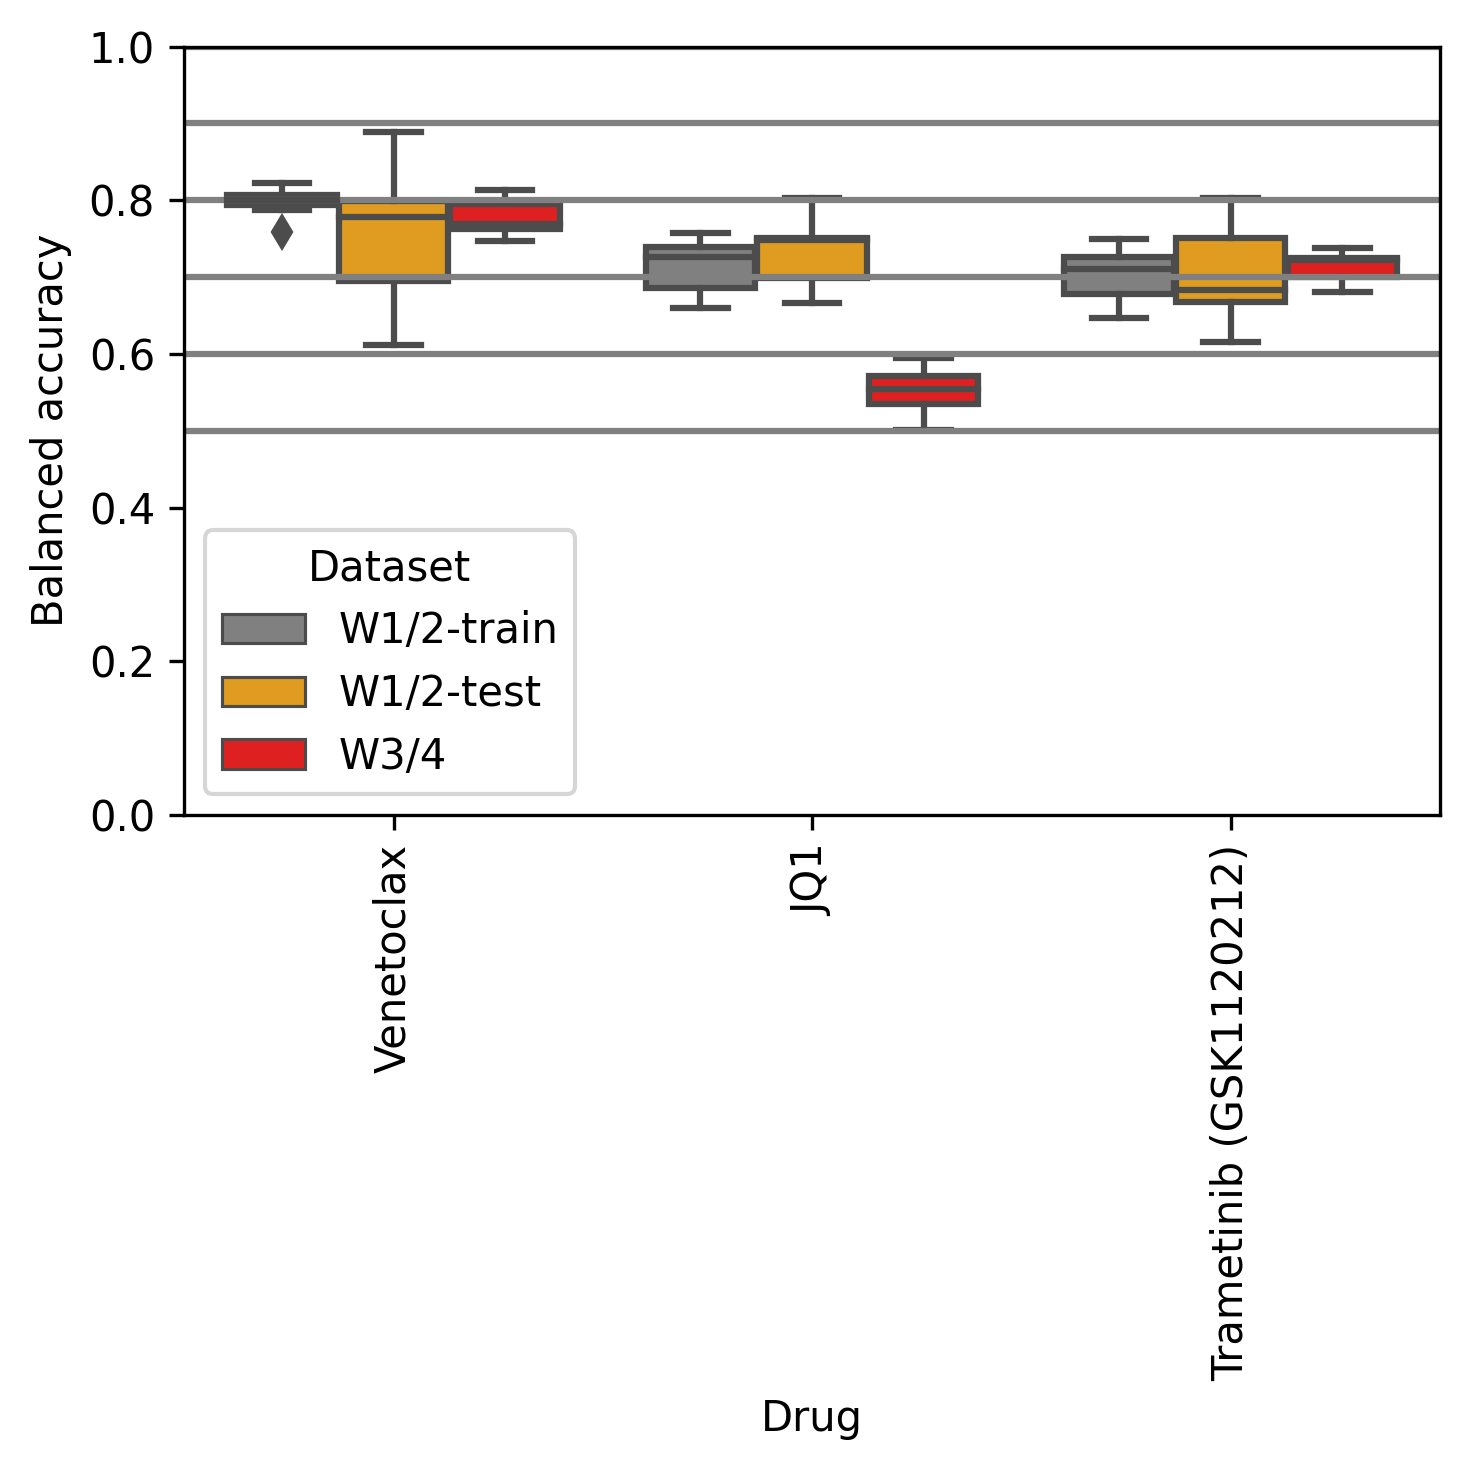

In [ ]:
import seaborn as sns
#plt.figure(figsize = (20,3),dpi = 300)
acc_df = pd.DataFrame({"Drug":list(selected_r['Drug'])+ list(selected_r['Drug']) + list(selected_r['Drug']),
                       "ACC":list(selected_r['ACC_train']) + list(selected_r['ACC1_2']) + list(selected_r['ACC_w3_4']),
                      ## "F1":list(selected_r['F1_train']) + list(selected_r['F1_w1_2']) + list(selected_r['F1_w3_4']),
                       "Dataset":['W1/2-train']*len(selected_r) + ['W1/2-test']*len(selected_r) + ['W3/4']*len(selected_r)})

#acc_df = pd.DataFrame({"Drug": list(selected_r['Drug']) + list(selected_r['Drug']),
#                       "ACC": list(selected_r['ACC1_2']) + list(selected_r['ACC_w3_4']),
#                       "F1": list(selected_r['F1_w1_2']) + list(selected_r['F1_w3_4']),
#                       "Dataset": ['W1/2-test']*len(selected_r) + ['W3/4']*len(selected_r)})

### F1                 
### ACC

plt.figure(figsize = (25,5),dpi = 300)

sns.boxplot(x="Drug", y="ACC",
            hue="Dataset", palette=["grey",'orange', "red"],
            order = order_drugs['Drug'],
            data=acc_df)

#plt.ylim(0,1)
#plt.title(Drug.split("(")[0])
plt.xticks(range(0,len(order_drugs['Drug'])), order_drugs['Drug'], rotation = 90)
plt.ylim(0,1)

#plt a line for y = 0.8
plt.axhline(y = 0.5, color = 'gray', linestyle = '-')
plt.axhline(y = 0.6, color = 'gray', linestyle = '-')
plt.axhline(y = 0.7, color = 'gray', linestyle = '-')
plt.axhline(y = 0.8, color = 'gray', linestyle = '-')
plt.axhline(y = 0.9, color = 'gray', linestyle = '-')
plt.axhline(y = 1, color = 'gray', linestyle = '-')

plt.ylabel("Balanced accuracy")
plt.tight_layout()
plt.savefig("Balanced_accuracy.pdf", dpi=300)
#plt.show()

In [ ]:
feature_drug_df = pd.DataFrame()
for drug in order_drugs['Drug']:
    print(drug)
    test = result_with_threshod[drug]
    #print(test)
    #print(sele_threshold[drug])
    cur = test[sele_threshold[drug]]
    #print(cur)
    feature_df = pd.DataFrame()
    for random in cur:
        if cur[random]['balanced_acc_training'] > 0.7 :
            feature_df_cur = cur[random]['features']
            feature_df_cur["IMP_"+str(random)]  = feature_df_cur['IMP']
            feature_df_cur.index = feature_df_cur['Feature']
            feature_df = pd.concat([feature_df, feature_df_cur["IMP_"+str(random)] ], axis =1)
    feature_df_sum = feature_df.sum(axis = 1)/feature_df.shape[1]
    result = pd.DataFrame({"features":feature_df_sum.index, 
                           "IMP":feature_df_sum.values, 
                           "Drug":[drug]*len(feature_df_sum.index)})
    
    feature_drug_df = pd.concat([feature_drug_df, result])

Venetoclax
Trametinib (GSK1120212)
JQ1


In [ ]:
feature_drug_df.to_csv("IMP_Feature_matrix_acc_gt0.7_Jun22.csv")

In [81]:
#feature_drug_df.loc[feature_drug_df['Drug'] == 'JQ1'].sort_values(by = ['IMP'], ascending = False).head(10)

,features,IMP,Drug
0,LGALS2-ZNF18,0.044892,JQ1
4,CASP5-MIR553,0.042982,JQ1
6,AATF-NFKB1,0.034899,JQ1
1,AC004014.4-MIR421,0.031914,JQ1
45,LGALS2-ZNF317,0.027912,JQ1
23,MED13L-SF3B2,0.027294,JQ1
12,CACNA2D3-ZNF853,0.025230,JQ1
10,CCL28-FNTA,0.024528,JQ1
13,TNS1-ZNF341,0.022151,JQ1
8,RNA18S5-RPS10,0.021656,JQ1
